<a href="https://colab.research.google.com/github/CASAttackZW2025/CAS502Project/blob/main/CAS502testv02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install simpy


In [ ]:
import simpy
import random
import matplotlib.pyplot as plt


In [ ]:
num_jobs = 50
arrival_rate = 1.0
processing_rate = 1.0

num_workers = 3
num_cranes = 1
num_test_kits = 1


crane_prob = 0.5
test_kit_prob = 0.3

shift_length = 6.5
break_length = 1.5
cycle_length = shift_length + break_length

In [ ]:
def process_during_shift(env, processing_time):
    remaining = processing_time
    while remaining > 0:
        cycle_time = env.now % cycle_length
        if cycle_time >= shift_length:
            wait_time = cycle_length - cycle_time
            yield env.timeout(wait_time)
        else:
            work_time_left = shift_length - cycle_time
            dt = min(remaining, work_time_left)
            yield env.timeout(dt)
            remaining -= dt

def job(env, name, worker, crane, test_kit, wait_times):
    arrival_time = env.now
    print(f'Job {name} arrives at {arrival_time:.2f}')

    with worker.request() as req:
        yield req
        needs_crane = random.random() < crane_prob
        needs_test_kit = random.random() < test_kit_prob
        processing_time = random.expovariate(processing_rate)
        start_time = env.now

        if needs_crane and needs_test_kit:
            with crane.request() as req_crane:
                yield req_crane
                with test_kit.request() as req_test:
                    yield req_test
                    print(f'Job {name} starts processing at {start_time:.2f} (with crane and test kit)')
                    yield from process_during_shift(env, processing_time)
                    finish_time = env.now
                    print(f'Job {name} finishes at {finish_time:.2f}')
        elif needs_crane:
            with crane.request() as req_crane:
                yield req_crane
                print(f'Job {name} starts processing at {start_time:.2f} (with crane)')
                yield from process_during_shift(env, processing_time)
                finish_time = env.now
                print(f'Job {name} finishes at {finish_time:.2f}')
        elif needs_test_kit:
            with test_kit.request() as req_test:
                yield req_test
                print(f'Job {name} starts processing at {start_time:.2f} (with test kit)')
                yield from process_during_shift(env, processing_time)
                finish_time = env.now
                print(f'Job {name} finishes at {finish_time:.2f}')
        else:
            print(f'Job {name} starts processing at {start_time:.2f}')
            yield from process_during_shift(env, processing_time)
            finish_time = env.now
            print(f'Job {name} finishes at {finish_time:.2f}')

        wait_times.append(start_time - arrival_time)

def job_generator(env, worker, crane, test_kit, wait_times):
    for i in range(num_jobs):
        yield env.timeout(random.expovariate(arrival_rate))
        env.process(job(env, i, worker, crane, test_kit, wait_times))



Job 0 arrives at 3.94
Job 0 starts processing at 3.94
Job 0 finishes at 4.68
Job 1 arrives at 4.94
Job 1 starts processing at 4.94
Job 2 arrives at 6.93
Job 2 starts processing at 6.93 (with test kit)
Job 3 arrives at 7.26
Job 4 arrives at 9.46
Job 1 finishes at 9.76
Job 2 finishes at 9.98
Job 3 starts processing at 7.26 (with crane and test kit)
Job 3 finishes at 10.01
Job 4 starts processing at 9.76 (with crane)
Job 4 finishes at 10.30
Job 5 arrives at 10.93
Job 5 starts processing at 10.93
Job 6 arrives at 12.70
Job 6 starts processing at 12.70
Job 6 finishes at 12.71
Job 7 arrives at 13.40
Job 7 starts processing at 13.40 (with crane and test kit)
Job 7 finishes at 13.54
Job 5 finishes at 13.97
Job 8 arrives at 14.04
Job 8 starts processing at 14.04 (with crane)
Job 9 arrives at 14.69
Job 10 arrives at 15.04
Job 10 starts processing at 15.04
Job 8 finishes at 16.04
Job 9 starts processing at 14.69 (with crane)
Job 11 arrives at 16.36
Job 10 finishes at 17.44
Job 12 arrives at 17.98

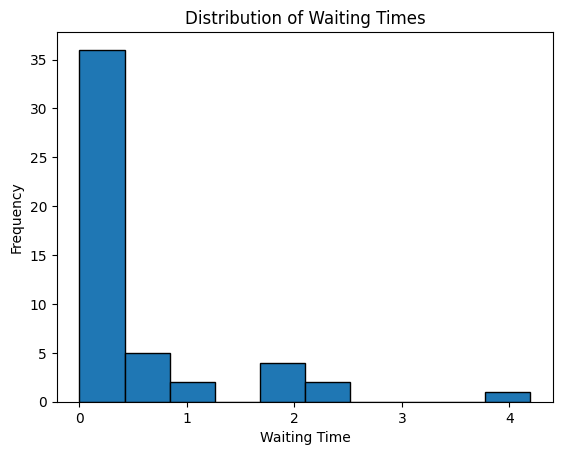

In [ ]:
def run_simulation():
    env = simpy.Environment()

    worker = simpy.Resource(env, capacity=num_workers)
    crane = simpy.Resource(env, capacity=num_cranes)
    test_kit = simpy.Resource(env, capacity=num_test_kits)

    wait_times = []
    env.process(job_generator(env, worker, crane, test_kit, wait_times))
    env.run()

    if wait_times:
        avg_wait = sum(wait_times) / len(wait_times)
        print(f"\nAverage waiting time: {avg_wait:.2f} time units")
        plt.hist(wait_times, bins=10, edgecolor='black')
        plt.title('Distribution of Waiting Times')
        plt.xlabel('Waiting Time')
        plt.ylabel('Frequency')
        plt.show()
    else:
        print("No jobs were processed.")


run_simulation()